In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.0 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
df = pd.read_csv('train.csv', delimiter=',', engine='python', encoding='utf-8', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 196: unexpected end of data


In [5]:
df.sample(10)

,id,title,author,text,label
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1
77,77,Judge spanks transgender-obsessed Obama: You l...,Redflag Newsdesk,"\nBob Unruh | WND \nFor a third time, a federa...",1
24,24,Abortion Pill Orders Rise in 7 Latin American ...,Donald G. McNeil Jr. and Pam Belluck,Orders for abortion pills by women in seven La...,0
156,156,The Battle at UNESCO,Ari Lieberman,"The Muslim Bloc may have won the battle, but d...",1
164,164,A Black Church Was Just Burned And Spray-Paint...,Colin Taylor,Comments \nTensions are mounting as the most v...,1
39,39,Avoiding Peanuts to Avoid an Allergy Is a Bad ...,Aaron E. Carroll,This article originally ran in April. We are r...,0
18,18,FBI Closes In On Hillary!,The Doc,FBI Closes In On Hillary! Posted on Home » Hea...,1
151,151,Students At Black College Just Got Beaten And ...,Colin Taylor,"Comments \nLast night, Louisiana Senate candid...",1
133,133,Donald Trump Unveils Plan for Families in Bid ...,Nick Corasaniti and Maggie Haberman,"ASTON, Pa. — Donald J. Trump unveiled a men...",0
181,181,You Don’t Like the Girls in ‘Girls’? That’s It...,Wesley Morris,"Normally, you’d be confused. Why would HBO low...",0


In [47]:
sentences = df.text.values
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df.label.values

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence")
print(tokenized_texts[0])

Tokenize the first sentence
['[CLS]', 'house', 'dem', 'aide', ':', 'we', 'didn', '’', 't', 'even', 'see', 'come', '##y', '’', 's', 'letter', 'until', 'jason', 'cha', '##ffe', '##tz', 't', '##wee', '##ted', 'it', 'by', 'darrell', 'luc', '##us', 'on', 'october', '30', ',', '2016', 'sub', '##scribe', 'jason', 'cha', '##ffe', '##tz', 'on', 'the', 'stump', 'in', 'american', 'fork', ',', 'utah', '(', 'image', 'courtesy', 'michael', 'jo', '##lley', ',', 'available', 'under', 'a', 'creative', 'commons', '-', 'by', 'license', ')', 'with', 'apologies', 'to', 'keith', 'ol', '##berman', '##n', ',', 'there', 'is', 'no', 'doubt', 'who', 'the', 'worst', 'person', 'in', 'the', 'world', 'is', 'this', 'week', '–', 'fbi', 'director', 'james', 'come', '##y', '.', 'but', 'according', 'to', 'a', 'house', 'democratic', 'aide', ',', 'it', 'looks', 'like', 'we', 'also', 'know', 'who', 'the', 'second', '-', 'worst', 'person', 'is', 'as', 'well', '.', 'it', 'turns', 'out', 'that', 'when', 'come', '##y', 'sent', 

In [8]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

In [41]:
sentences[50]

'[CLS] 0 0 With humanity’s awakening continuing to speed up as every day passes, we see more and more people desiring information to help them better themselves. Whether that is done through eating healthier foods, beginning a yoga or meditation practice, or whether it is done by being more mindful with the words they choose to use when having an inner dialogue or a conversation with friends and family, more people are looking for information to help them transform their lives in a positive way. While there are many methods to improving one’s life, below are some methods that can help a person spark an inner revolution to create positive and uplifting change in his or her world. Grounding/Earthing Grounding, or what is also called Earthing is when a person has bare skin touching the Earth or a tree and is most commonly done by standing on the Earth with one’s bare feet. Doing this begins to balance the electrochemical state of the body because of the negative ions the Earth emits. Nega

In [9]:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [10]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)


In [11]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [12]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [13]:
from transformers import BertModel, BertConfig
configuration = BertConfig()

model = BertModel(configuration)
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [21]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 

optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [24]:
epochs = 8

optimizer = AdamW(optimizer_grouped_parameters,
                 lr=2e-5)
total_steps = len(train_dataloader) * epochs

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)


In [26]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:
t = []

train_loss_set = []

for _ in trange(epochs, desc='Epoch'):
  model.train()

  tr_loss = 0
  nb_tr_examples, nb_tr_setps = 0,0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  model.eval()
  eval_loss, tot_eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    eval_accuracy = flat_accuracy(logits, label_ids)

    tot_eval_accuracy += eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:  10%|█         | 1/10 [00:03<00:31,  3.54s/it]

Train loss: 0.6925369004408518
Validation Accuracy: 0.35


Epoch:  20%|██        | 2/10 [00:07<00:28,  3.55s/it]

Train loss: 0.6351026097933451
Validation Accuracy: 0.4


Epoch:  30%|███       | 3/10 [00:10<00:24,  3.54s/it]

Train loss: 0.5725196202596029
Validation Accuracy: 0.75


Epoch:  40%|████      | 4/10 [00:14<00:21,  3.54s/it]

Train loss: 0.4202133466800054
Validation Accuracy: 0.85


Epoch:  50%|█████     | 5/10 [00:17<00:17,  3.55s/it]

Train loss: 0.2971259206533432
Validation Accuracy: 0.85


Epoch:  60%|██████    | 6/10 [00:21<00:14,  3.56s/it]

Train loss: 0.2007736215988795
Validation Accuracy: 0.85


Epoch:  70%|███████   | 7/10 [00:24<00:10,  3.57s/it]

Train loss: 0.14962495987613997
Validation Accuracy: 0.9


Epoch:  80%|████████  | 8/10 [00:28<00:07,  3.59s/it]

Train loss: 0.09956798205773036
Validation Accuracy: 0.9


Epoch:  90%|█████████ | 9/10 [00:32<00:03,  3.61s/it]

Train loss: 0.09443618729710579
Validation Accuracy: 0.9


Epoch: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it]

Train loss: 0.07886990780631702
Validation Accuracy: 0.9


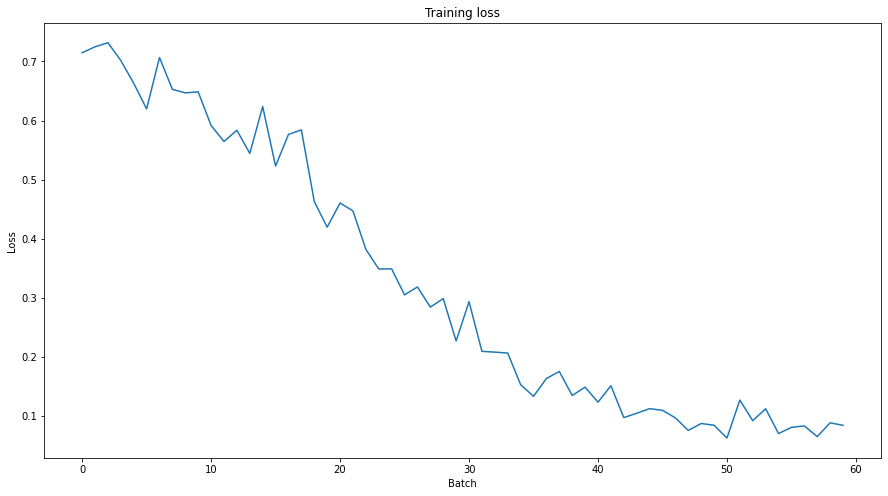

In [28]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()